In [1]:
import os
import time

import keras
import numpy as np
import optuna
import pandas as pd
import sklearn
import talib
import tensorflow as tf
import tensorflow_addons as tfa
import yfinance as yf
from keras.callbacks import Callback, CSVLogger, EarlyStopping, ModelCheckpoint
from keras.layers import (
    LSTM,
    GRU,
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from keras.models import Sequential
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from tensorflow.keras.metrics import *

In [2]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [3]:
SEED = 42


def set_random_seed():
    tf.keras.utils.set_random_seed(SEED)


def HMA(df: pd.DataFrame, timeperiod: int = 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(
        2 * talib.WMA(df, int(timeperiod / 2)) - talib.WMA(df, timeperiod),
        int(np.sqrt(timeperiod)),
    )
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = (
        df["Volume"]
        * (2 * df["Close"] - df["High"] - df["Low"])
        / (df["High"] - df["Low"])
    )
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df["Volume"].rolling(timeperiod).sum()


def pltcolor(lst: list) -> list:
    cols = []
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append("green")
        elif lst.iloc[i] == 2:
            cols.append("red")
    return cols


def trendNormalizePrices(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29, len(df)):
        model = LinearRegression()
        model.fit(
            np.array(df["rowNumber"].iloc[i - 29 : i + 1]).reshape(-1, 1),
            np.array(df["Close"].iloc[i - 29 : i + 1]),
        )
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1, 1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction
    df["Open"] = df["TN_Open"]
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(
        columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1
    )
    return df


def create_labels(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0] - 10):
        s = set(df["Close"].iloc[i : i + 11])
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i + 11):
            if df["Close"].iloc[j] == minPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 1
            elif df["Close"].iloc[j] == maxPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 2
    return df.iloc[6:-6]


def reverse_one_hot(predictions: np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions: np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0, 0, 0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)
    return np.array(predictions_one_hot)


def number_null_and_nan(df: pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return na + null

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [4]:
prices = yf.download(
    "SPY",
    start="2009-09-20",
    end="2023-01-01",
    interval="1d",
    progress=False,
    auto_adjust=True,
)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-09-21 00:00:00-04:00,82.204681,83.066399,82.026131,82.639420,151892000
2009-09-22 00:00:00-04:00,83.128515,83.353649,82.755878,83.120750,143126700
2009-09-23 00:00:00-04:00,83.314808,83.865995,82.282299,82.429802,225947400
2009-09-24 00:00:00-04:00,82.608382,82.786932,81.164423,81.521530,228636800
2009-09-25 00:00:00-04:00,81.342987,81.793255,80.807323,81.086800,204059000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,70911500


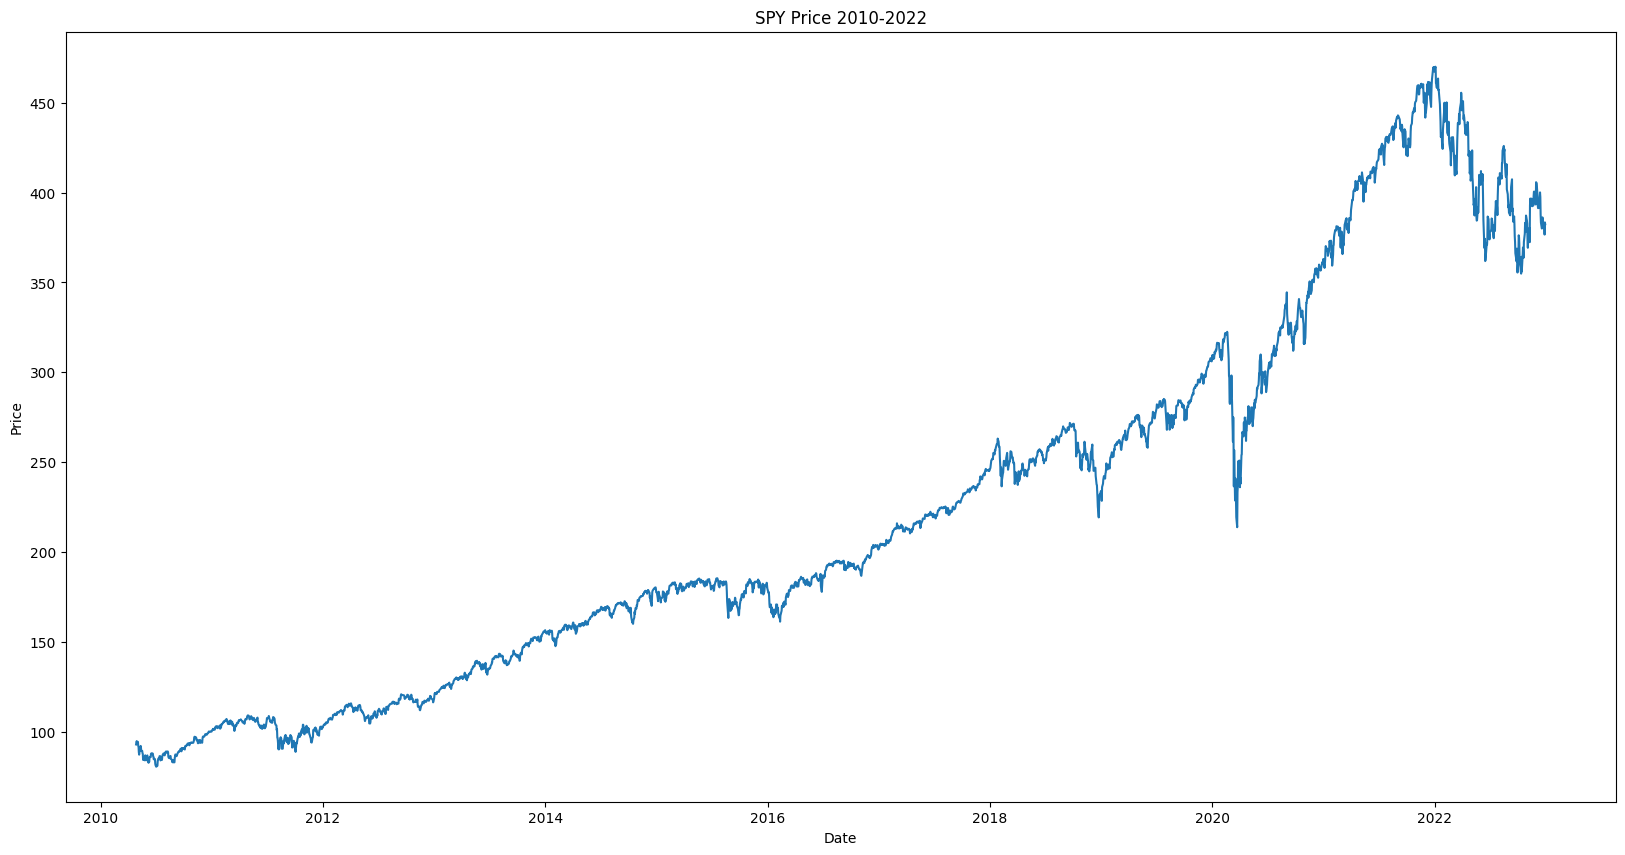

In [5]:
plt.figure(figsize=(20, 10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [6]:
tn_prices = trendNormalizePrices(prices)
tn_prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-11-02 00:00:00-05:00,-2.497192,-1.503495,-3.312326,-2.349689,254222900
2009-11-03 00:00:00-05:00,-2.646063,-1.823158,-2.801325,-1.939608,228362600
2009-11-04 00:00:00-05:00,-1.110653,-0.474069,-1.778290,-1.568686,247996700
2009-11-05 00:00:00-05:00,-0.968831,-0.021724,-1.139623,-0.045013,180015300
2009-11-06 00:00:00-05:00,-0.467016,0.417990,-0.630042,0.208380,170954100
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,-7.306054,-3.896050,-8.926049,-4.046044,59857300
2022-12-27 00:00:00-05:00,-2.835277,-2.475292,-5.975292,-4.225292,51638200
2022-12-28 00:00:00-05:00,-2.236787,-0.176759,-7.146761,-6.906770,70911500


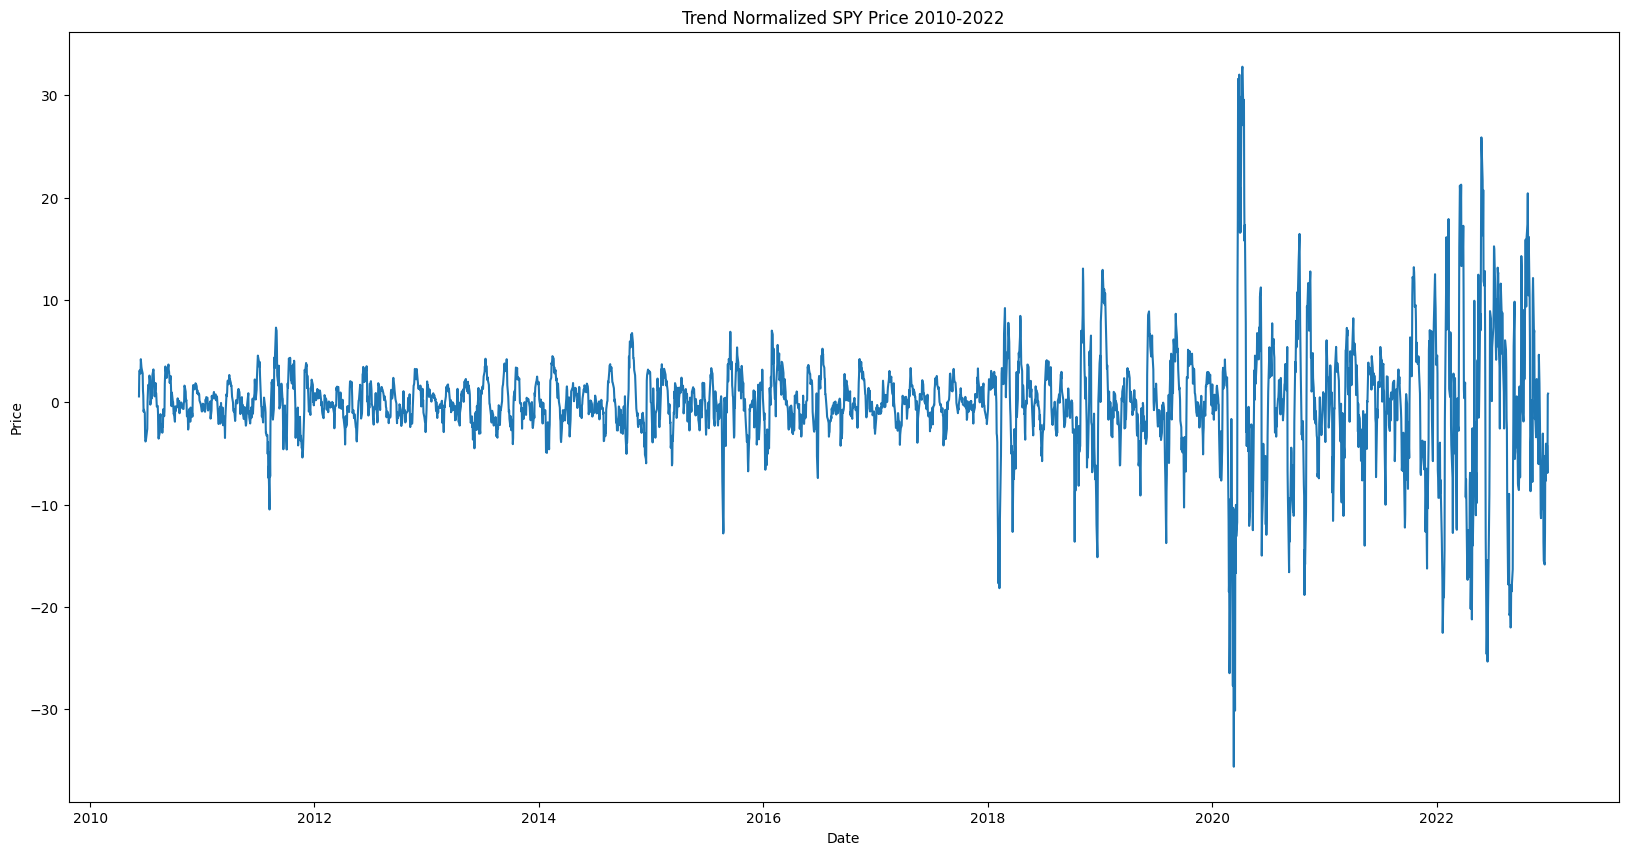

In [7]:
plt.figure(figsize=(20, 10))
plt.title("Trend Normalized SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(tn_prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [8]:
prices_and_indicators = tn_prices.copy()

In [9]:
for i in range(7, 30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i + 7,
        slowk_period=i - 4,
    )[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i - 2,
        fastd_period=i - 4,
    )[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"HMA-{i}"] = HMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(
        prices_and_indicators["Close"], fastlimit=1 / i, slowlimit=1 / (i + 14)
    )[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(
        prices_and_indicators["Close"], timeperiod=i
    )[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(
        prices_and_indicators["High"], prices_and_indicators["Low"], maximum=1 / i
    )
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        fastperiod=i - 4,
        slowperiod=i + 3,
    )
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(
        prices_and_indicators["Close"], timeperiod=i
    )[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod=i)
prices_and_indicators["BOP"] = talib.BOP(
    prices_and_indicators["Open"],
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["TRANGE"] = talib.TRANGE(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["SAREXT"] = talib.SAREXT(
    prices_and_indicators["High"], prices_and_indicators["Low"]
)
prices_and_indicators["AD"] = talib.AD(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
    prices_and_indicators["Volume"],
)
prices_and_indicators["OBV"] = talib.OBV(
    prices_and_indicators["Close"], prices_and_indicators["Volume"]
)
prices_and_indicators.dropna(inplace=True)

C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

In [10]:
prices_and_indicators

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,ADXR-21,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [11]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS_DI-29,M

In [12]:
prices_and_indicators_with_label["Label"].value_counts()

0    2796
1     216
2     205
Name: Label, dtype: int64

<Figure size 5000x3000 with 0 Axes>

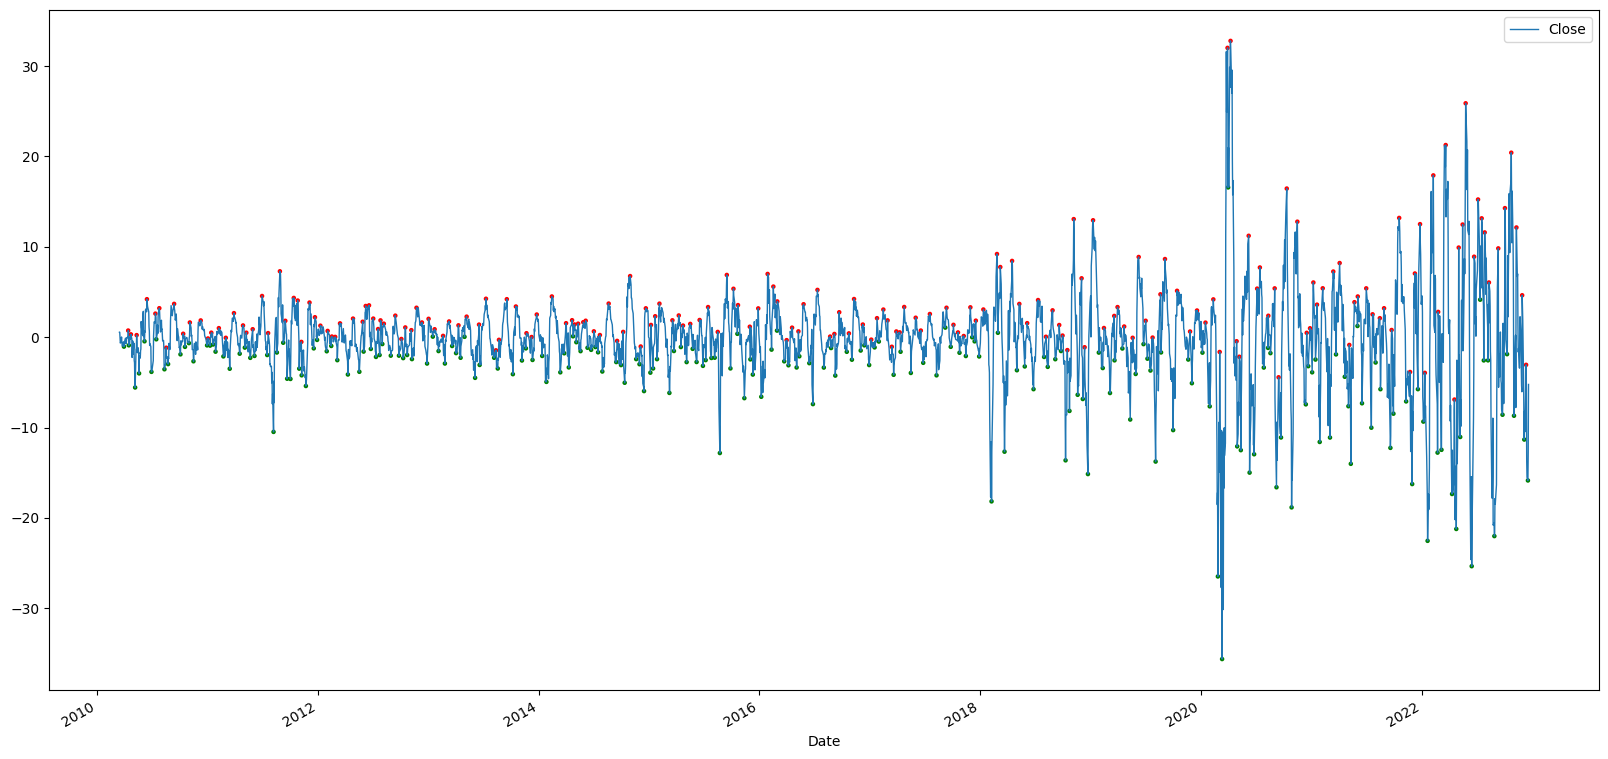

In [13]:
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(
    kind="line", stacked=False, linewidth=1
)
buy_and_sell_preds = prices_and_indicators_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<Figure size 5000x3000 with 0 Axes>

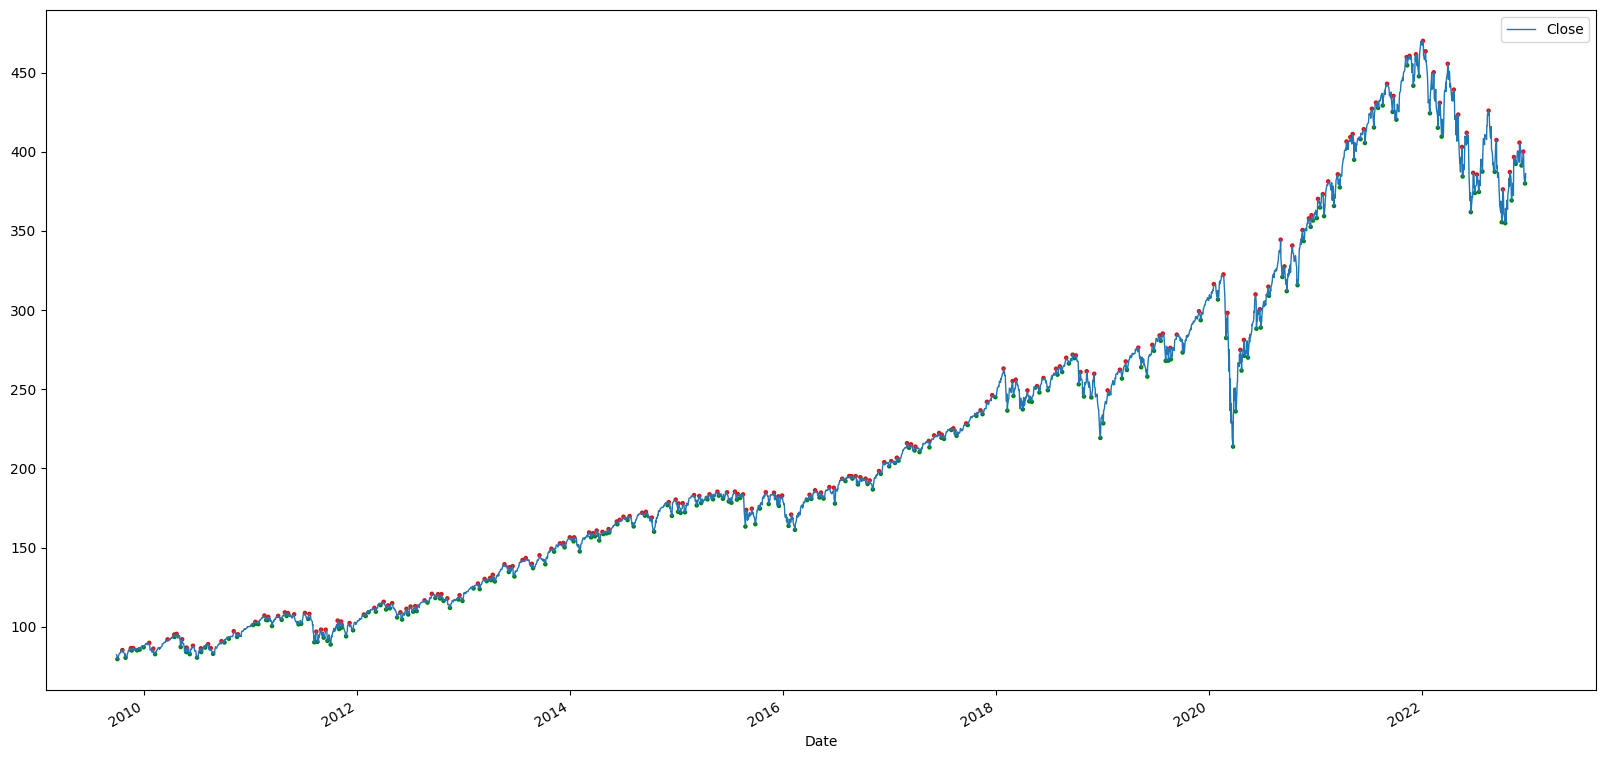

In [14]:
prices_with_label = create_labels(prices)
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_with_label[["Close"]].plot(kind="line", stacked=False, linewidth=1)
buy_and_sell_preds = prices_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [15]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-03-16 00:00:00-04:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.7 MB


In [16]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i-5}")
        & (prices_and_indicators_with_label.index <= f"{2010+i}")
    ]
    test = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i}")
        & (prices_and_indicators_with_label.index <= f"{2010+i+1}")
    ]
    datas.append([train, test])

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [17]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k=selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:, :-1], datas[i][0].iloc[:, -1])
    train_features = fitted.transform(datas[i][0].iloc[:, :-1])
    test_features = fitted.transform(datas[i][1].iloc[:, :-1])

    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label

    datas[i][0] = pd.DataFrame(
        data=train_features.astype("float32"),
        columns=selected_features,
        index=datas[i][0].index,
    )
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(
        data=test_features.astype("float32"),
        columns=selected_features,
        index=datas[i][1].index,
    )
    datas[i][1]["Label"] = test_label

In [18]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,37.759228,-52.956966,55.303375,-24.481544,39.590527,-58.703739,48.986626,-20.818951,41.267338,-58.703739,47.043034,-17.465321,42.725250,41.296261,-14.549499,41.296261,38.374172,37.566322,36.875881,36.292263,35.784439,35.331264,34.932762,34.587936,34.276787,34.001339,33.767925,33.553074,33.349403,33.157921,0
2010-03-17 00:00:00-04:00,37.573593,-51.518482,68.045547,-24.852814,39.431370,-53.442032,54.733135,-21.137260,41.128399,-59.129551,48.481518,-17.743198,42.602371,46.557968,-14.795254,40.870449,43.798183,42.831982,42.007847,41.312202,40.707897,40.169449,39.696575,39.287796,38.919392,38.593601,38.317711,38.064026,37.823757,37.598064,0
2010-03-18 00:00:00-04:00,28.815437,-75.484612,30.962440,-42.369125,31.711020,-78.284760,30.478115,-36.577961,34.253315,-79.146332,24.515385,-31.493370,36.432945,21.715237,-27.134111,20.853666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-19 00:00:00-04:00,21.401930,-82.355484,19.092077,-57.196140,24.677382,-84.927689,17.840317,-50.645237,27.633835,-86.248955,17.644512,-44.732330,30.235889,15.072309,-39.528221,13.751043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-22 00:00:00-04:00,29.433268,-56.419369,46.038528,-41.133465,31.282375,-56.809647,46.038528,-37.435249,33.145081,-62.088688,43.580631,-33.709839,34.901035,43.190353,-30.197929,37.911312,28.038694,27.256123,26.581524,26.002089,25.494619,25.042009,24.641298,24.289091,23.971195,23.687071,23.438864,23.211084,22.997967,22.799368,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,71.148697,-34.315521,40.716812,42.297398,69.421669,-33.947327,63.216740,38.843338,67.860954,-33.947327,65.684479,35.721909,66.457939,66.052673,32.915878,66.052673,38.985039,41.147617,43.002857,44.607864,46.007000,47.235168,48.320137,49.284241,50.145592,50.919014,51.616730,52.248890,52.823975,53.349125,0
2014-12-26 00:00:00-05:00,72.135880,-34.939629,70.907410,44.271763,70.322334,-32.595573,43.688175,40.644665,68.696426,-32.245834,65.060371,37.392845,67.240990,67.404427,34.481979,67.754166,41.009071,42.018658,42.944183,43.792858,44.571613,45.286949,45.944889,46.550964,47.110191,47.627110,48.577003,49.677433,50.677422,51.589577,0
2014-12-29 00:00:00-05:00,70.688965,-57.835415,50.269592,41.377934,69.129128,-35.884964,63.719078,38.258259,67.681503,-33.477489,42.164585,35.363003,66.358383,64.115036,32.716770,66.522507,6.390550,7.620410,8.740033,9.761082,10.693974,11.548000,12.331425,13.051599,13.715043,14.327541,14.894223,15.419632,15.907801,16.362305,0


In [19]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,42.520935,-7.703912e+01,23.589090,-14.958129,44.853783,-7.703912e+01,23.589090,-10.292438,46.391548,-7.703912e+01,22.960886,-7.216900,47.422104,22.960886,-5.155793,22.960886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-05 00:00:00-05:00,27.882917,-9.515693e+01,5.039054,-44.234165,31.124605,-9.524712e+01,4.843070,-37.750790,33.593433,-9.524712e+01,4.843070,-32.813133,35.501305,4.752872,-28.997395,4.752872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-06 00:00:00-05:00,24.230692,-8.982867e+01,11.567370,-51.538616,27.512703,-8.982867e+01,10.501949,-44.974594,30.088890,-8.998254e+01,10.171334,-39.822220,32.133087,10.171334,-35.733829,10.017458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2015-01-07 00:00:00-05:00,43.844265,-5.927781e+01,45.624264,-12.311468,44.374222,-6.055980e+01,44.853443,-11.251554,44.875553,-6.055980e+01,40.722187,-10.248891,45.310097,39.440201,-9.379808,39.440201,72.643494,71.864212,71.199974,70.625748,70.123146,69.678436,69.281197,68.923431,68.598869,68.302582,68.030602,67.779732,67.547333,67.331230,0
2015-01-08 00:00:00-05:00,58.889614,-1.480960e+01,96.452888,17.779230,57.928005,-2.265612e+01,86.654427,15.856008,57.213081,-2.509101e+01,85.190399,14.426161,56.644547,77.343880,13.289095,74.908997,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2
2015-01-09 00:00:00-05:00,50.927490,-3.386783e+01,71.318153,1.854978,50.846016,-3.498513e+01,71.318153,1.692035,50.813686,-4.097337e+01,66.132172,1.627372,50.794140,65.014870,1.588276,59.026630,75.166542,75.074791,74.993217,74.919846,74.853180,74.792053,74.735573,74.683052,74.633949,74.587814,74.544304,74.503136,74.464073,74.426910,0
2015-01-12 00:00:00-05:00,44.741070,-4.808213e+01,51.917870,-10.517859,45.298050,-5.185740e+01,51.917870,-9.403896,45.765556,-5.267077e+01,51.917870,-8.468890,46.151478,48.142601,-7.697047,47.329231,54.976784,54.752205,54.550007,54.366253,54.197895,54.042557,53.898380,53.763874,53.637856,53.519348,53.407551,53.301800,53.201523,53.106239,0
2015-01-13 00:00:00-05:00,43.234241,-5.285314e+01,28.193190,-13.531515,43.950230,-5.285314e+01,47.146858,-12.099538,44.541313,-5.628148e+01,47.146858,-10.917376,45.026909,47.146858,-9.946180,43.718521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-14 00:00:00-05:00,39.824585,-6.324912e+01,32.366165,-20.350828,40.918316,-6.324912e+01,32.366165,-18.163372,41.800270,-6.324912e+01,36.750881,-16.399458,42.518547,36.750881,-14.962909,36.750881,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [20]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(
        data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index
    )
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(
        data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index
    )
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [21]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,0.445696,-0.529570,0.553034,-0.350311,0.481724,-0.587037,0.489866,-0.323426,0.516425,-0.587037,0.470430,-0.291968,0.548755,0.412963,-0.259983,0.412963,0.383742,0.375663,0.368759,0.362923,0.357844,0.353313,0.349328,0.345879,0.342768,0.340013,0.337679,0.335531,0.333494,0.331579,0.0
2010-03-17 00:00:00-04:00,0.443505,-0.515185,0.680455,-0.355624,0.479788,-0.534420,0.547331,-0.328371,0.514686,-0.591296,0.484815,-0.296613,0.547177,0.465580,-0.264375,0.408704,0.437982,0.428320,0.420078,0.413122,0.407079,0.401694,0.396966,0.392878,0.389194,0.385936,0.383177,0.380640,0.378238,0.375981,0.0
2010-03-18 00:00:00-04:00,0.340127,-0.754846,0.309624,-0.606268,0.385849,-0.782848,0.304781,-0.568245,0.428651,-0.791463,0.245154,-0.526475,0.467938,0.217152,-0.484857,0.208537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-19 00:00:00-04:00,0.252621,-0.823555,0.190921,-0.818430,0.300266,-0.849277,0.178403,-0.786782,0.345813,-0.862490,0.176445,-0.747791,0.388344,0.150723,-0.706326,0.137510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-22 00:00:00-04:00,0.347420,-0.564194,0.460385,-0.588586,0.380633,-0.568096,0.460385,-0.581563,0.414782,-0.620887,0.435806,-0.563528,0.448263,0.431904,-0.539604,0.379113,0.280387,0.272561,0.265815,0.260021,0.254946,0.250420,0.246413,0.242891,0.239712,0.236871,0.234389,0.232111,0.229980,0.227994,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,0.839814,-0.343155,0.407168,0.605241,0.844699,-0.339473,0.632167,0.603438,0.849221,-0.339473,0.656845,0.597164,0.853574,0.660527,0.588170,0.660527,0.389850,0.411476,0.430029,0.446079,0.460070,0.472352,0.483201,0.492842,0.501456,0.509190,0.516167,0.522489,0.528240,0.533491,0.0
2014-12-26 00:00:00-05:00,0.851466,-0.349396,0.709074,0.633493,0.855658,-0.325956,0.436882,0.631421,0.859676,-0.322458,0.650604,0.625097,0.863631,0.674044,0.616155,0.677542,0.410091,0.420187,0.429442,0.437929,0.445716,0.452869,0.459449,0.465510,0.471102,0.476271,0.485770,0.496774,0.506774,0.515896,0.0
2014-12-29 00:00:00-05:00,0.834387,-0.578354,0.502696,0.592085,0.841140,-0.358850,0.637191,0.594348,0.846975,-0.334775,0.421646,0.591164,0.852295,0.641150,0.584612,0.665225,0.063906,0.076204,0.087400,0.097611,0.106940,0.115480,0.123314,0.130516,0.137150,0.143275,0.148942,0.154196,0.159078,0.163623,0.0


In [22]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,0.501902,-7.703912e-01,0.235891,-0.214039,0.545766,-7.703912e-01,0.235891,-0.159895,0.580550,-7.703912e-01,0.229609,-0.120645,0.609081,0.229609,-0.092128,0.229609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-05 00:00:00-05:00,0.329120,-9.515693e-01,0.050391,-0.632955,0.378714,-9.524712e-01,0.048431,-0.586465,0.420393,-9.524712e-01,0.048431,-0.548538,0.455972,0.047529,-0.518151,0.047529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-06 00:00:00-05:00,0.286010,-8.982867e-01,0.115674,-0.737476,0.334765,-8.982867e-01,0.105019,-0.698688,0.376536,-8.998254e-01,0.101713,-0.665709,0.412712,0.101713,-0.638524,0.100175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2015-01-07 00:00:00-05:00,0.517522,-5.927781e-01,0.456243,-0.176167,0.539931,-6.055980e-01,0.448534,-0.174795,0.561579,-6.055980e-01,0.407222,-0.171331,0.581955,0.394402,-0.167607,0.394402,0.726435,0.718642,0.712000,0.706257,0.701231,0.696784,0.692812,0.689234,0.685989,0.683026,0.680306,0.677797,0.675473,0.673312,0.0
2015-01-08 00:00:00-05:00,0.695112,-1.480960e-01,0.964529,0.254406,0.704848,-2.265612e-01,0.866544,0.246326,0.715972,-2.509101e-01,0.851904,0.241162,0.727532,0.773439,0.237461,0.749090,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
2015-01-09 00:00:00-05:00,0.601130,-3.386783e-01,0.713182,0.026543,0.618677,-3.498513e-01,0.713182,0.026286,0.635889,-4.097337e-01,0.661322,0.027205,0.652391,0.650149,0.028381,0.590266,0.751665,0.750748,0.749932,0.749198,0.748532,0.747921,0.747356,0.746831,0.746339,0.745878,0.745443,0.745031,0.744641,0.744269,0.0
2015-01-12 00:00:00-05:00,0.528108,-4.808213e-01,0.519179,-0.150502,0.551171,-5.185740e-01,0.519179,-0.146091,0.572716,-5.267077e-01,0.519179,-0.141575,0.592761,0.481426,-0.137538,0.473292,0.549768,0.547522,0.545500,0.543663,0.541979,0.540426,0.538984,0.537639,0.536379,0.535193,0.534076,0.533018,0.532015,0.531062,0.0
2015-01-13 00:00:00-05:00,0.510322,-5.285314e-01,0.281932,-0.193625,0.534772,-5.285314e-01,0.471469,-0.187968,0.557396,-5.628148e-01,0.471469,-0.182506,0.578317,0.471469,-0.177727,0.437185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-14 00:00:00-05:00,0.470075,-6.324912e-01,0.323662,-0.291204,0.497880,-6.324912e-01,0.323662,-0.282171,0.523094,-6.324912e-01,0.367509,-0.274150,0.546100,0.367509,-0.267371,0.367509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [23]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


<h1 style="font-size:40px;"> <center> INITIAL MODELS </center> </h1>

<h1 style="font-size:30px;"> Model Architectures </h1>

In [83]:
def create_model_MLP(activation_func="swish", dropout_rate=0.2, optimizer_algo="adam"
):
    MLP = Sequential()
    MLP.add(
        Dense(
            64,
            input_shape=(30, ),
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.HeUniform(),
        )
    )
   # MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation="softmax"))
    MLP.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return MLP

In [25]:
def create_model_LSTM(
    activation_func="swish", dropout_rate=0.2, optimizer_algo="adam"
):
    LSTM_model = Sequential()
    LSTM_model.add(
        LSTM(
            units=64,
            return_sequences=True,
            input_shape=(30, 30),
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
        )
    )
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(LSTM(units=32, return_sequences=True, activation=activation_func))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate))
    LSTM_model.add(LSTM(units=32, return_sequences=False, activation=activation_func))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate))
    LSTM_model.add(Dense(3, activation="softmax"))
    LSTM_model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return LSTM_model

In [26]:
def create_model_GRU(
    activation_func="swish", dropout_rate=0.2, optimizer_algo="adam"
):
    GRU_model = Sequential()
    GRU_model.add(
        GRU(
            units=64,
            return_sequences=True,
            input_shape=(30, 30),
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
        )
    )
    GRU_model.add(BatchNormalization())
    GRU_model.add(GRU(units=32, return_sequences=True, activation=activation_func))
    GRU_model.add(BatchNormalization())
    GRU_model.add(Dropout(dropout_rate))
    GRU_model.add(GRU(units=32, return_sequences=False, activation=activation_func))
    GRU_model.add(BatchNormalization())
    GRU_model.add(Dropout(dropout_rate))
    GRU_model.add(Dense(3, activation="softmax"))
    GRU_model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return GRU_model

In [27]:
def create_model_CNN_2D(
    activation_func="relu",
    dropout_rate=0.2,
    optimizer_algo="adam",
    kernel=3,
    pooling=3,
):
    CNN_2D = Sequential()
    CNN_2D.add(
        Conv2D(
            filters=64,
            kernel_size=(kernel, kernel),
            input_shape=(30, 30, 1),
            padding="same",
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.HeUniform(),
        )
    )
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling), padding="same"))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(
        Conv2D(
            filters=64,
            kernel_size=(kernel, kernel),
            padding="same",
            activation=activation_func,
        )
    )
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling), padding="same"))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Flatten())
    CNN_2D.add(Dense(32, activation=activation_func))
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Dense(3, activation="softmax"))
    CNN_2D.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return CNN_2D

In [89]:
datas[3][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,WILLR-10,STOCHF-10,CMO-10,RSI-11,WILLR-11,STOCHF-11,CMO-11,RSI-12,WILLR-12,STOCHF-12,CMO-12,RSI-13,STOCHF-13,CMO-13,RSI-14,STOCHF-14,CMO-14,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00-05:00,0.796738,-0.013620,0.986380,0.453900,0.794434,-0.013620,0.986380,0.420225,0.795183,-0.013620,0.986380,0.390308,0.798139,-0.013620,0.986380,0.366353,0.802655,-0.013620,0.986380,0.347067,0.808234,-0.013620,0.986380,0.331450,0.814495,0.986380,0.318730,0.821152,0.986380,0.308306,2.0
2013-01-03 00:00:00-05:00,0.736300,-0.114448,0.885552,0.321089,0.739502,-0.114448,0.885552,0.296153,0.744561,-0.114448,0.885552,0.273724,0.751005,-0.114448,0.885552,0.255625,0.758420,-0.114448,0.885552,0.241035,0.766462,-0.114448,0.885552,0.229263,0.774853,0.885552,0.219743,0.783378,0.885552,0.212025,0.0
2013-01-04 00:00:00-05:00,0.751537,-0.073967,0.922980,0.354571,0.754178,-0.073967,0.926033,0.329302,0.758727,-0.073967,0.926033,0.306350,0.764696,-0.073967,0.926033,0.287787,0.771662,-0.073967,0.926033,0.272776,0.779279,-0.073967,0.926033,0.260617,0.787267,0.926033,0.250741,0.795411,0.926033,0.242695,0.0
2013-01-07 00:00:00-05:00,0.681536,-0.177832,0.814828,0.200747,0.691798,-0.177832,0.814828,0.188405,0.702084,-0.177832,0.822168,0.175900,0.712554,-0.177832,0.822168,0.165296,0.723166,-0.177832,0.822168,0.156531,0.733813,-0.177832,0.822168,0.149395,0.744374,0.822168,0.143641,0.754741,0.822168,0.139033,0.0
2013-01-08 00:00:00-05:00,0.610890,-0.300266,0.230263,0.045505,0.628565,-0.288365,0.699734,0.045584,0.644482,-0.288365,0.699734,0.043239,0.659390,-0.288365,0.711635,0.040403,0.673610,-0.288365,0.711635,0.037744,0.687263,-0.288365,0.711635,0.035519,0.700382,0.711635,0.033793,0.712963,0.711635,0.032545,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 00:00:00-05:00,0.429842,-0.842050,0.157950,-0.352342,0.462858,-0.842050,0.157950,-0.328693,0.492558,-0.842050,0.157950,-0.306645,0.519524,-0.842050,0.157950,-0.288168,0.544168,-0.842050,0.157950,-0.272529,0.566796,-0.842050,0.157950,-0.259179,0.587650,0.157950,-0.247696,0.606922,0.157950,-0.237744,0.0
2017-12-26 00:00:00-05:00,0.377658,-0.928446,0.085765,-0.467016,0.414298,-0.928446,0.071554,-0.438374,0.446976,-0.928446,0.071554,-0.411622,0.476438,-0.928446,0.071554,-0.389386,0.503211,-0.928446,0.071554,-0.370704,0.527685,-0.928446,0.071554,-0.354858,0.550162,0.071554,-0.341302,0.570881,0.071554,-0.329608,0.0
2017-12-27 00:00:00-05:00,0.365088,-0.928869,0.105781,-0.494636,0.402565,-0.928869,0.084619,-0.464874,0.435944,-0.928869,0.071131,-0.437029,0.466000,-0.928869,0.071131,-0.413907,0.493283,-0.928869,0.071131,-0.394499,0.518202,-0.928869,0.071131,-0.378054,0.541072,0.071131,-0.363997,0.562142,0.071131,-0.351881,0.0


<h1 style="font-size:30px;"> Train&Test Methods </h1>

In [99]:
def model_train_test(model_name, datas):
    set_random_seed()

    start_time = time.time()
    predictions = []
    f1_scores = []
    
    model_creations = {"MLP": create_model_MLP, "LSTM": create_model_LSTM, 
                   "GRU": create_model_GRU, "CNN-2D": create_model_CNN_2D }
    create_model = model_creations[model_name]

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(
            monitor="val_f1_score", mode="max", verbose=1, patience=30, min_delta=1e-3
        )
        mcp = ModelCheckpoint(
            os.path.join(OUTPUT_PATH, f"best_{model_name}_model-{i+1}.h5"),
            monitor="val_f1_score",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="max",
        )
        
        
        if model_name == "MLP":     
            val_split_point = int(0.8 * len(datas[i][0]))
            X_train = datas[i][0][:val_split_point].iloc[:, :-1]
            y_train = tf.keras.utils.to_categorical(
                datas[i][0][:val_split_point].iloc[:, -1], num_classes=3
            )
            X_val = datas[i][0][val_split_point:].iloc[:, :-1]
            y_val = tf.keras.utils.to_categorical(
                datas[i][0][val_split_point:].iloc[:, -1], num_classes=3
            )
            X_test = datas[i][1].iloc[:, :-1]
            y_test = datas[i][1].iloc[:, -1]
        else:
            val_split_point = int(0.8 * len(datas[0][i]))
            X_train = datas[0][i][:val_split_point]
            y_train = datas[1][i][:val_split_point]
            X_val = datas[0][i][val_split_point:]
            y_val = datas[1][i][val_split_point:]
            X_test = datas[2][i]
            y_test = datas[3][i]

            
        model = create_model()
        model.fit(
            X_train,
            y_train,
            batch_size=64,
            epochs=200,
            verbose=0,
            #callbacks=[es, mcp],
            validation_data=(X_val, y_val),
            class_weight={0: 1, 1: 10, 2: 10},
        )
        y_pred = model.predict(X_test)
        y_pred = y_pred.argmax(axis=-1)
        #print(y_test)
        #print(y_pred)
        predictions.append(y_pred)
        f1_scores.append(f1_score(y_test, y_pred, average="macro"))

    print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
    minutes = round(int(time.time() - start_time) / 60, 2)
    print(f"\nCompleted in {minutes} minutes\n")

<h1 style="font-size:30px;"> Matrix Data Creation </h1>

In [64]:
two_d_datas = []

for i in range(len(datas)):
    df = datas[i][0].drop(columns=["Label"])
    df_matrix_train = pd.DataFrame(
        index=df.iloc[29:].index,
    )
    df_matrix_train["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

    for j in range(df_matrix_train.shape[0]):
        matrix = df.iloc[j : j + 30].values.reshape((30, 30, -1))
        df_matrix_train.iloc[j, 0] = matrix
    df_matrix_train["Label"] = datas[i][0].iloc[29:, -1]

    df = datas[i][1].drop(columns=["Label"])
    df_matrix_test = pd.DataFrame(
        index=df.iloc[29:].index,
    )
    df_matrix_test["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

    for j in range(df_matrix_test.shape[0]):
        matrix = df.iloc[j : j + 30].values.reshape((30, 30, -1))
        df_matrix_test.iloc[j, 0] = matrix
    df_matrix_test["Label"] = datas[i][1].iloc[29:, -1]

    two_d_datas.append((df_matrix_train, df_matrix_test))

In [ ]:
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []
matrix_datas = []

for i in range(len(two_d_datas)):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for j in range(two_d_datas[i][0].shape[0]):
        X_train.append(two_d_datas[i][0].iloc[j, 0])
        y_train.append(
            tf.keras.utils.to_categorical(two_d_datas[i][0].iloc[j, 1], num_classes=3)
        )
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(
        X_train, newshape=(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    )
    X_train_list.append(X_train)
    y_train_list.append(y_train)

    for j in range(two_d_datas[i][1].shape[0]):
        X_test.append(two_d_datas[i][1].iloc[j, 0])
        y_test.append(two_d_datas[i][1].iloc[j, 1])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(
        X_test, newshape=(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    )
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    
matrix_datas = [X_train_list, y_train_list, X_test_list, y_test_list]

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [100]:
model_train_test("MLP", datas)

8/8 [==============================] - 0s 2ms/step

Average f1-macro score: 0.5287547396708677


Completed in 3.27 minutes



<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [57]:
model_train_test("LSTM", matrix_datas)

e
7/7 [==============================] - 1s 13ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 2. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 1 0 0 0 0 0 2 0 2 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 2 0 0 1 

KeyboardInterrupt: 

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [ ]:
model_train_test("GRU", matrix_datas)

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [ ]:
model_train_test("CNN-2D", matrix_datas)

<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
set_random_seed()
start_time = time.time()


def objective(trial):
    activation_func = trial.suggest_categorical(
        name="activation_func", choices=["relu", "selu", "swish"]
    )
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.1, 0.2, 0.3])
    optimizer_algo = trial.suggest_categorical(
        "optimizer_algo", ["adam", "adadelta", "rmsprop"]
    )
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 256])
    # epoch_num = trial.suggest_categorical("epoch_number", [50, 100, 200])
    #lr_max = trial.suggest_categorical("learning_rate_max", [1e-1, 1e-2, 1e-3, 1e-4])

    model = create_model_MLP(activation_func, dropout_rate, optimizer_algo)

    f1_scores = []

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(
            monitor="f1_score", mode="max", verbose=1, patience=20, min_delta=1e-2
        )
        mcp = ModelCheckpoint(
            os.path.join(OUTPUT_PATH, f"best_CNN_model-{i+1}.h5"),
            monitor="f1_score",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="max",
        )

        val_split_point = int(0.5 * len(datas[i][0]))
        X_train = datas[i][0][:val_split_point].iloc[:, :-1]
        y_train = tf.keras.utils.to_categorical(
            datas[i][0][:val_split_point].iloc[:, -1], num_classes=3
        )
        X_val = datas[i][0][val_split_point:].iloc[:, :-1]
        y_val = datas[i][0][val_split_point:].iloc[:, -1]

        model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=100,
            verbose=0,
            callbacks=[es, mcp],
            class_weight={0: 1, 1: 10, 2: 10},
        )
        y_pred = model.predict(X_val)
        y_pred = y_pred.argmax(axis=-1)
        f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    return np.mean(f1_scores)


study = optuna.create_study(
    study_name="MLP_Bayesian_Optimization",
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
)
study.optimize(objective, n_trials=30)
trial = study.best_trial

print("\n------------------------------------------")
print("Best F1 Macro: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
minutes = round(int(time.time() - start_time) / 60, 2)
print(f"\nCompleted in {minutes} minutes")

In [ ]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(
        monitor="val_f1_score", mode="max", verbose=1, patience=20, min_delta=1e-2
    )
    mcp = ModelCheckpoint(
        os.path.join(OUTPUT_PATH, f"best_CNN_model-{i+1}.h5"),
        monitor="val_f1_score",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
    )

    val_split_point = int(0.5 * len(datas[i][0]))
    X_train = datas[i][0][:val_split_point].iloc[:, :-1]
    y_train = tf.keras.utils.to_categorical(
        datas[i][0][:val_split_point].iloc[:, -1], num_classes=3
    )
    X_val = datas[i][0][val_split_point:].iloc[:, :-1]
    y_val = tf.keras.utils.to_categorical(
        datas[i][0][val_split_point:].iloc[:, -1], num_classes=3
    )
    X_test = datas[i][1].iloc[:, :-1]
    y_test = datas[i][1].iloc[:, -1]

    model = create_model_MLP(trial.params["activation_func"], trial.params["drop_out_rate"], trial.params["optimizer_algorithm"])
    model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=100,
        verbose=0,
        callbacks=[es, mcp],
        validation_data=(X_val, y_val),
        class_weight={0: 1, 1: 10, 2: 10},
    )
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    print(y_test)
    print(y_pred)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))

print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time) / 60, 2)
print(f"\nCompleted in {minutes} minutes\n")



<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>